## Table of context

1. [Load packages](#load-packages)
2. [Load dataset](#load-dataset)
3. [Overview of dataset](#overview-of-dataset)
4. [Data visualization](#data-visualization)  
    4.1 [Imbalanced target](#imbalanced-target)  
    4.2 [Distributions of numerical variables](#distributions-of-numerical-variables)  
    4.3 [Numerical variables VS target](#numerical-variables-VS-target)  
    4.4 [Correlation-among-variables](#correlation-among-variables)  
5. [Handling missing values](#handling-missing-values)  
    5.1 [Drop MA_DEC and EA_RATIO,or not?](#drop-MA_DEC-and-EA_RATIO-,-or-not-?)  
    5.2 [Imputation with median in CWS, MWS and EF](#imputation-with-median-in-CWS-,-MWS-and-EF)  
    5.3 [Multiple imputation in LA, LVIDS and LVIDD](#Multiple-imputation-in-LA-,-LVIDS-and-LVIDD)  
6. [Data modeling](#data-modeling)  
    6.1 [RandomForest Classifier](#randomforest-classifier)  
    6.2 [XGBoost Classifier](#xgboost-classifier)    
7. [Conclusion](#conclusion)

<a id='load-packages'></a>
## Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer ## multiple imputation
%matplotlib inline

from sklearn.feature_selection import RFECV ## feature selection

from sklearn.impute import SimpleImputer
from statistics import mean, median

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score,StratifiedKFold

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

<a id='load-dataset'></a>
## Load dataset

In [76]:
df=pd.read_excel('../Data/cerner.xlsx', sheet_name='data')

<a id='overview-of-dataset'></a>
## Overview of dataset

In [77]:
print('data shape:', df.shape)
display(df.head())

data shape: (778, 9)


,LVIDD,LVIDS,LA,EF,MA_DEC,EA_RATIO,MWS,CWS,Y
0,5.7,?,3.7,58,?,?,249.3,456.47,Normal.
1,7.7,6.6,?,20,?,?,260.92,443.43,LVH.
2,6.2,4.3,4.6,59,?,?,255.63,478.96,LVH.
3,5.7,4.4,3.8,49,?,?,195.28,381.94,Normal.
4,9.1,?,4.6,17,?,?,259.55,395.67,LVH.


The misssing values are filled with '?', I would like to use np.nan to replace '?'.

In [78]:
df=df.replace('?', np.nan)

In [79]:
df.describe()

,LVIDD,LVIDS,LA,EF,MA_DEC,EA_RATIO,MWS,CWS
count,596.000000,565.000000,528.000000,768.000000,274.000000,275.000000,762.000000,758.000000
mean,5.913423,4.753097,4.174432,36.881510,179.394161,1.497818,220.332808,420.421161
std,0.980767,1.223359,0.837119,14.372681,107.244362,1.366011,69.137602,103.712913
min,3.900000,2.100000,2.200000,5.000000,42.000000,0.250000,69.520000,176.880000
25%,5.200000,3.800000,3.600000,25.000000,107.000000,0.655000,172.402500,348.567500
50%,5.800000,4.700000,4.100000,35.000000,151.000000,0.970000,210.815000,412.150000
75%,6.450000,5.600000,4.700000,47.000000,228.000000,1.820000,258.280000,482.687500
max,9.100000,8.400000,8.200000,79.000000,696.000000,9.800000,531.710000,788.180000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LVIDD     596 non-null    float64
 1   LVIDS     565 non-null    float64
 2   LA        528 non-null    float64
 3   EF        768 non-null    float64
 4   MA_DEC    274 non-null    float64
 5   EA_RATIO  275 non-null    float64
 6   MWS       762 non-null    float64
 7   CWS       758 non-null    float64
 8   Y         778 non-null    object 
dtypes: float64(8), object(1)
memory usage: 54.8+ KB


<a id='data-visualization'></a>
## Data visualization
<a id='imbalanced-target'></a>
### Imbalanced target
The base rate of y is around 82%, so the data set is imbalanced. Must keep this in mind when train models.

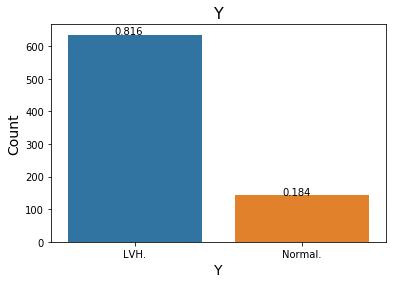

In [7]:
ax1 = sns.countplot(x='Y', data=df, order = df.Y.value_counts().index)
for p in ax1.patches:
    ax1.annotate('{0:.3}'.format(p.get_height()/len(df)), (p.get_x()+0.28, p.get_height()+0.8))
ax1.set_title("Y", fontsize='16')
ax1.set_ylabel('Count', fontsize='14')
ax1.set_xlabel('Y',fontsize='14')

plt.show()

<a id='distributions-of-numerical-variables'></a>
### Distributions of numeric variables

In [8]:
## Extract the list of features
features=list(df.columns)
features.remove('Y')

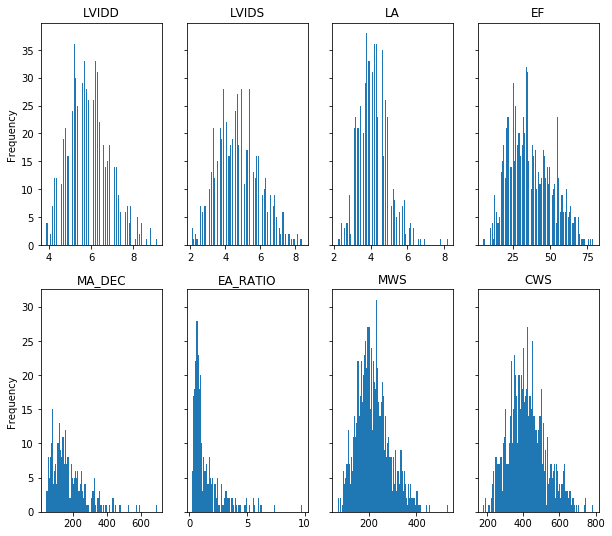

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey= 'row', figsize=(10,9))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[0,2]
ax4=axes[0,3]
ax5=axes[1,0]
ax6=axes[1,1]
ax7=axes[1,2]
ax8=axes[1,3]

df.LVIDD.plot(kind='hist', bins=100, ax=ax1, log=False)
df.LVIDS.plot(kind='hist', bins=100,ax=ax2, log=False)
df.LA.plot(kind='hist', bins=100,ax=ax3, log=False)
df.EF.plot(kind='hist', bins=100, ax=ax4, log=False)
df.MA_DEC.plot(kind='hist', bins=100,ax=ax5, log=False)
df.EA_RATIO.plot(kind='hist', bins=100,ax=ax6, log=False)
df.MWS.plot(kind='hist', bins=100,ax=ax7, log=False)
df.CWS.plot(kind='hist', bins=100,ax=ax8, log=False)


ax1.title.set_text('LVIDD')
ax2.title.set_text('LVIDS')
ax3.title.set_text('LA')
ax4.title.set_text('EF')
ax5.title.set_text('MA_DEC')
ax6.title.set_text('EA_RATIO')
ax7.title.set_text('MWS')
ax8.title.set_text('CWS')

plt.show()

From the outplots above, except MA_DEC and EA_RATIO, most of the distributions are approximately normally distributed

<a id='numerical-variables-VS-target'></a>
### Numerical variables VS target

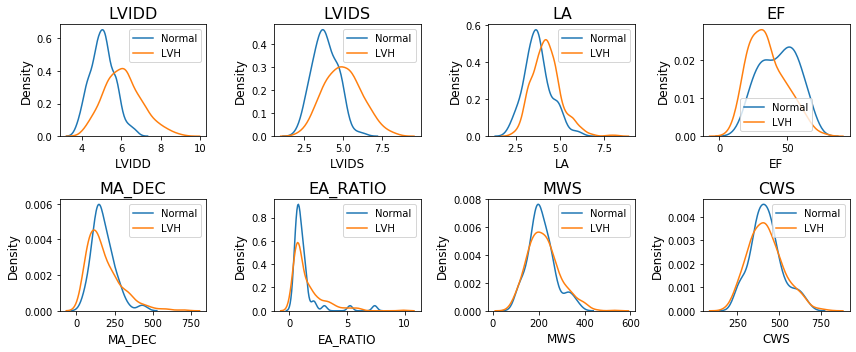

In [10]:
fig= plt.subplots(figsize=(12, 5))
ax1 = plt.subplot2grid((2, 4), (0, 0))
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (0, 2))
ax4 = plt.subplot2grid((2, 4), (0, 3))
ax5 = plt.subplot2grid((2, 4), (1, 0))
ax6 = plt.subplot2grid((2, 4), (1, 1))
ax7 = plt.subplot2grid((2, 4), (1, 2))
ax8 = plt.subplot2grid((2, 4), (1, 3))

ax=[]
ax.extend((ax1,ax2,ax3, ax4,ax5,ax6,ax7,ax8))

for i in range(8):
    df2 = df[df.Y == 'Normal.']
    sns.distplot(df2[features[i]], hist =False, kde = True, label='Normal', ax=ax[i])
    df2 = df[df.Y =='LVH.']
    sns.distplot(df2[features[i]], hist =False, kde = True, label='LVH', ax=ax[i])
    
    ax[i].set_xlabel(features[i], fontsize=12)
    ax[i].set_ylabel('Density', fontsize=12)
    ax[i].set_title(features[i], fontsize=16)
    plt.tight_layout()
    i += 1
    
plt.show()

From the outplot above, all the variables, epspecially LVIDD, LVIDS, and EF, have different distributions in Y= Normal and Y= LVH. It seems that all of these variables have great effective on target.

<a id='correlation-among-variables'></a>
### Correlation among variables

To check if there are highly correlated features which would be removed before modeling.

The correlation between LVIDD and LVIDS is 0.93, the correlation between CWS and MWS is 0.97.

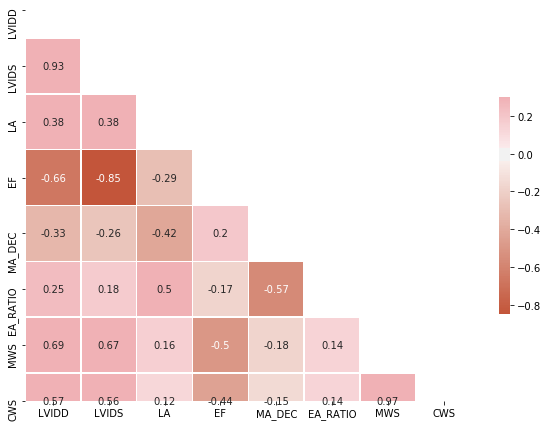

In [11]:
corr=df[features].corr(method='pearson')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10,8))
cmap = sns.diverging_palette(20, 10, as_cmap=True)
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<a id='handling-missing-values'></a>
## Handling missing values 

In [80]:
df_NA=pd.DataFrame(df[features].isna().sum(), columns=['Count'])
df_NA['% Missing']=100*(df_NA.Count/len(df))
df_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
MA_DEC,504,64.781491
EA_RATIO,503,64.652956
LA,250,32.133676
LVIDS,213,27.377892
LVIDD,182,23.393316
CWS,20,2.570694
MWS,16,2.056555
EF,10,1.285347


From the table above, each variables contain missing values. 

1. The missing rate in both MA_DEC and EA_RATIO is around 65%, I would like to explore if I can not include them before modeling.
2. Since the missing rate in CWS, MWS and EF is less than 5%, I would like to use median to impute missing values. 
3. The missing rate in  LA, LVIDS and LVIDD is from 20 ~ 35%, I would like to use multiple imputation to impute missing values. 



<a id='drop-MA_DEC-and-EA_RATIO-,-or-not-?'></a>
### Drop MA_DEC and EA_RATIO, or not?

In [81]:
## convert the target from string into number
df.loc[df.Y=='Normal.', 'Y']=0
df.loc[df.Y=='LVH.', 'Y']=1

## convert the data type of Y into int
df['Y']=pd.to_numeric(df['Y'])

Split dataset into train and test

In [82]:
X=df.copy()
X=X.drop(columns=['Y'])
X.fillna('na')
y=df.Y


## split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)

Split dataset into new train and validation

In [83]:
## split X_train into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

Run a baseline XGBClassifier

In [29]:
## Baseline XGBClassifier
xgb = XGBClassifier(class_weight='balanced') ## Since base rate of shroke is very rare, data should be balanced

xgb_baseline_train = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=10).mean()
xgb_baseline_val = cross_val_score(xgb, X_val, y_val, scoring='roc_auc',cv=10).mean()

print('train_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_train))
print('val_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_val))

train_xgb_baseline ROC_AUC: 0.882
val_xgb_baseline ROC_AUC: 0.836


In [30]:
X_train_2=X_train.drop(columns=['MA_DEC','EA_RATIO'])
X_val_2=X_val.drop(columns=['MA_DEC','EA_RATIO'])
## Baseline XGBClassifier
xgb = XGBClassifier(class_weight='balanced') ## Since base rate of shroke is very rare, data should be balanced

xgb_baseline_train = cross_val_score(xgb, X_train_2, y_train, scoring='roc_auc', cv=10).mean()
xgb_baseline_val = cross_val_score(xgb, X_val_2, y_val, scoring='roc_auc',cv=10).mean()

print('train_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_train))
print('val_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_val))

train_xgb_baseline ROC_AUC: 0.889
val_xgb_baseline ROC_AUC: 0.832


XGBoostClassfier is robust to missing values, that's why I choose it to check if I can drop MA_DEC and EA_RATIO or not. Comparing the two baseline models with or without these two variables, the AUC values on validation are very close. So I would like to drop these two varibales from the dataset.

In [84]:
df=df.drop(columns=['MA_DEC','EA_RATIO'])

<a id='imputation-with-median-in-CWS-,-MWS-and-EF'></a>
### Imputation with median in CWS, MWS and EF

In order to avoid data leakage, I use train median to impute missing values in both train and test.

In [85]:
X=df.copy()
X=X.drop(columns=['Y'])
X.fillna('na')
y=df.Y

## split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)

In [86]:
## imputate missing value in train and test
ls=['CWS','MWS','EF']
for ele in ls:
    X_train.loc[X_train[ele].isna(), ele]=median(X_train[ele])
    X_test.loc[X_test[ele].isna(), ele]=median(X_train[ele])  

<a id='Multiple-imputation-in-LA-,-LVIDS-and-LVIDD'></a>
### Multiple imputation in LA, LVIDS and LVIDD
If I have more time, I would like to do multiple imputation several times, and use different imputed data for modeling. But here I only did once.

In [91]:
imp = IterativeImputer(random_state=0)

X_train_imp=imp.fit_transform(X_train)

X_test_imp=imp.transform(X_test)


In [93]:
X_train_imp=pd.DataFrame(X_train_imp, columns=['LVIDD', 'LVIDS', 'LA', 'EF', 'MWS', 'CWS'])

In [95]:
X_test_imp=pd.DataFrame(X_test_imp, columns=['LVIDD', 'LVIDS', 'LA', 'EF', 'MWS', 'CWS'])

In [96]:
## split X_train into training and validation 
X_train_imp, X_val_imp, y_train, y_val = train_test_split(X_train_imp, y_train, test_size=0.25, random_state=2019)

<a id='data-modeling'></a>
## Data modeling
<a id='randomforest-classifier'></a>
### RandomForest Classifier

RandomForest classifier is a tree-based algorithm, it has the following advantages:
1. robust to outliers.
2. quick train/prediction speed.
3. provides the scores about feature importance, which can let you know the relationship features have with the target and the degree of influence they have on target. 

Baseline RandomForest model with imputed data

In [97]:
## Baseline RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced') ## Since base rate of shroke is very rare, data should be balanced

rf_baseline_train = cross_val_score(rf, X_train_imp, y_train, scoring='roc_auc', cv=10).mean()
rf_baseline_val = cross_val_score(rf, X_val_imp, y_val, scoring='roc_auc',cv=10).mean()

print('train_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('val_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_val))

train_rf_baseline ROC_AUC: 0.921
val_rf_baseline ROC_AUC: 0.942


#### Tune hyperparameters for RandomForest classifier with BayesianOptimization

What does BayesianOptimization do? Build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function. Advantages compared to GridSearch and RandomSearch:
1. quick tuning speed
2. search space is large and continous

In [114]:
def rf_evaluate( n_estimators, max_depth, min_samples_split, min_samples_leaf,max_leaf_nodes): 
    rf_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'min_samples_split':int(min_samples_split), 
                   'min_samples_leaf':int(min_samples_leaf),
                   'max_leaf_nodes':int(max_leaf_nodes),
                   'n_jobs':-1, 
                   'random_state':42 
               }
     
    cv_result= cross_val_score(RandomForestClassifier(**rf_params, class_weight='balanced'),  ## ** unpack params for the function call
               X=X_train_imp, 
               y=y_train, 
               cv=10,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

rf_params = {"n_estimators": (100, 1000),
            "max_depth": (3,20),
            "min_samples_split": (2, 15),
            'min_samples_leaf':(2,20),
            "max_leaf_nodes": (10, 40)
            }


rf_bo = BayesianOptimization(rf_evaluate , rf_params)

In [115]:
rf_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.9112   |  7.156    |  35.26    |  6.405    |  8.042    |  501.3    |
|  2        |  0.9067   |  6.119    |  28.03    |  8.139    |  8.475    |  589.5    |
|  3        |  0.9057   |  10.5     |  28.81    |  9.308    |  8.697    |  305.8    |
|  4        |  0.909    |  19.57    |  27.01    |  8.556    |  14.5     |  228.1    |
|  5        |  0.8967   |  19.44    |  28.24    |  19.41    |  13.79    |  412.3    |
|  6        |  0.9124   |  14.83    |  39.38    |  2.057    |  8.021    |  993.3    |
|  7        |  0.9071   |  4.894    |  39.07    |  2.556    |  13.47    |  101.8    |
|  8        |  0.9153   |  19.57    |  38.21    |  2.023    |  2.737    |  559.6    |
|  9        |  0.9106   |  19.04    |  37.52    |  2.03     |  14.41    |  403.5    |
|  10       |  0.9039   |  19.41    |  10.78    |  3.0

In [116]:
## get the best parameters 
rf_params = rf_bo.max['params']

print(rf_params)

{'max_depth': 19.573915567200878, 'max_leaf_nodes': 38.21017350940369, 'min_samples_leaf': 2.0233579361270504, 'min_samples_split': 2.736885274618527, 'n_estimators': 559.6498102532316}


In [117]:
rf_tuned = RandomForestClassifier(max_depth=19, 
                                  min_samples_split=2, 
                                  n_estimators= 559, 
                                  min_samples_leaf=2,
                                  max_leaf_nodes=38,
                                  class_weight='balanced')
                                 
rf_tuned = rf_tuned.fit(X_train_imp, y_train)

rf_tuned_train_ROC_AUC = cross_val_score(rf_tuned, X_train_imp, y_train, scoring='roc_auc').mean()
rf_tuned_val_ROC_AUC = cross_val_score(rf_tuned, X_val_imp, y_val, scoring='roc_auc').mean()

print('train_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('train_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_train_ROC_AUC))

print(' ')

print('val_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_val))
print('val_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_val_ROC_AUC))

train_rf_baseline ROC_AUC: 0.921
train_rf_tuned ROC_AUC: 0.909
 
val_rf_baseline ROC_AUC: 0.942
val_rf_tuned ROC_AUC: 0.939


From the results above, it seems the performance of baseline model is a little bit better than the tunded one. Since the time limitation, I would not like to spend to much time for tuning. 

#### Make prediction on test

In [118]:
rf_test_ROC_AUC = cross_val_score(rf, X_test_imp, y_test, scoring='roc_auc').mean()
rf_tuned_test_ROC_AUC = cross_val_score(rf_tuned, X_test_imp, y_test, scoring='roc_auc').mean()

print('test_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('test_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_train_ROC_AUC))

test_rf_baseline ROC_AUC: 0.921
test_rf_tuned ROC_AUC: 0.909


#### Feature importance
Feature importance rank from baseline model

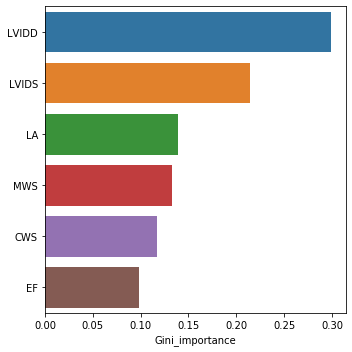

In [125]:
rf = rf.fit(X_train_imp, y_train)
rf_fscores=pd.DataFrame(rf.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_imp.columns, rf_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

rf_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini_importance'})

plt.figure(figsize=(5, 5))
importances=rf_importances.sort_values(by='Gini_importance', ascending=False)
sns.barplot(x='Gini_importance', y=importances.index, data=importances)
plt.tight_layout()
plt.show()

Feature importance rank from tuned model

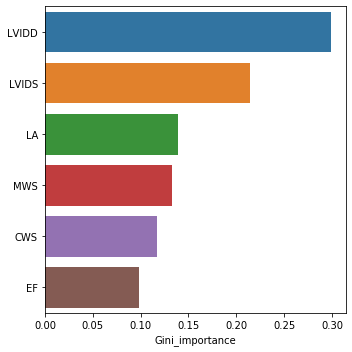

In [121]:
rf_fscores=pd.DataFrame(rf_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_imp.columns, rf_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

rf_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini_importance'})

plt.figure(figsize=(5, 5))
importances=rf_importances.sort_values(by='Gini_importance', ascending=False)
sns.barplot(x='Gini_importance', y=importances.index, data=importances)
plt.tight_layout()
plt.show()

The rank of the features are roughly consistent with the insights from data visualization

<a id='xgboost-classifier'></a>
### XGBoost Classifier
Baseline XGBoostClassifier

In [98]:
## Baseline XGBClassifier
xgb = XGBClassifier(class_weight='balanced') ## Since base rate of shroke is very rare, data should be balanced

xgb_baseline_train = cross_val_score(xgb, X_train_imp, y_train, scoring='roc_auc', cv=10).mean()
xgb_baseline_val = cross_val_score(xgb, X_val_imp, y_val, scoring='roc_auc',cv=10).mean()

print('train_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_train))
print('val_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_val))

train_xgb_baseline ROC_AUC: 0.917
val_xgb_baseline ROC_AUC: 0.908


#### Tuner hyperparameter for XGBoostClassifier

In [99]:
def xgb_evaluate( n_estimators, max_depth,learning_rate, colsample_bytree,subsample,gamma): 
    xgb_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'learning_rate':learning_rate, 
                   'colsample_bytree':colsample_bytree,
                   'subsample':subsample,
                   'gamma':gamma, 
                   'random_state':42 
               }
     
    cv_result= cross_val_score(XGBClassifier(**xgb_params, class_weight='balanced'),  ## ** unpack params for the function call
               X=X_train_imp, 
               y=y_train, 
               cv=10,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

xgb_params = {"n_estimators": (300, 1000),
            "max_depth": (3, 20),
            "learning_rate": (0.01, 0.1),
            'colsample_bytree':(0.8,1),
            "subsample": (0.8, 1),
              'gamma':(0,5)
              
            }


xgb_bo = BayesianOptimization(xgb_evaluate , xgb_params)

In [100]:
xgb_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9147   |  0.9284   |  2.505    |  0.0874   |  18.42    |  674.2    |  0.9199   |
|  2        |  0.9194   |  0.8319   |  0.6837   |  0.059    |  18.44    |  764.4    |  0.9175   |
|  3        |  0.9181   |  0.9607   |  0.9161   |  0.01006  |  11.31    |  397.2    |  0.8215   |
|  4        |  0.918    |  0.8757   |  1.06     |  0.04411  |  12.12    |  525.1    |  0.8173   |
|  5        |  0.9174   |  0.9703   |  2.692    |  0.09365  |  7.104    |  470.4    |  0.9406   |
|  6        |  0.9211   |  0.9285   |  1.886    |  0.05435  |  3.224    |  999.5    |  0.833    |
|  7        |  0.9096   |  0.9907   |  4.686    |  0.03441  |  3.416    |  999.9    |  0.9665   |
|  8        |  0.9047   |  0.9957   |  0.006439 |  0.06614  |  3.207    |  727.9    |  0.9683   |
|  9        |  0.907

In [56]:
## get the best parameters 
xgb_params = xgb_bo.max['params']

print(xgb_params)

{'colsample_bytree': 0.8601696435763482, 'gamma': 0.0026021168855544508, 'learning_rate': 0.011055593320367704, 'max_depth': 3.266765858472574, 'n_estimators': 637.8485201587903, 'subsample': 0.9482101673140436}


In [101]:
xgb_tuned = XGBClassifier(colsample_bytree=0.8601696435763482,
                          gamma=0.0026021168855544508,
                          learning_rate=0.011055593320367704,
                          max_depth=3,
                          n_estimators=637,
                          subsample= 0.9482101673140436,
                          class_weight='balanced')
                                 
xgb_tuned = xgb_tuned.fit(X_train_imp, y_train)

xgb_tuned_train_ROC_AUC = cross_val_score(xgb_tuned, X_train_imp, y_train, scoring='roc_auc').mean()
xgb_tuned_val_ROC_AUC = cross_val_score(xgb_tuned, X_val_imp, y_val, scoring='roc_auc').mean()

print('train_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_train))
print('train_xgb_tuned ROC_AUC: {0:.3}'.format(xgb_tuned_train_ROC_AUC))

print(' ')

print('val_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_val))
print('val_xgb_tuned ROC_AUC: {0:.3}'.format(xgb_tuned_val_ROC_AUC))

train_xgb_baseline ROC_AUC: 0.917
train_xgb_tuned ROC_AUC: 0.92
 
val_xgb_baseline ROC_AUC: 0.908
val_xgb_tuned ROC_AUC: 0.889


The model perfomance on train has been improved by tuning, but not in validation set. Since the limitation of time, I would not like to spend more time to tune model.

#### Prediction on test

In [107]:
xgb_test_ROC_AUC = cross_val_score(xgb, X_test_imp, y_test, scoring='roc_auc').mean()
xgb_tuned_test_ROC_AUC = cross_val_score(xgb_tuned, X_test_imp, y_test, scoring='roc_auc').mean()

print('test_xgb_baseline ROC_AUC: {0:.3}'.format(xgb_baseline_train))
print('test_xgb_tuned ROC_AUC: {0:.3}'.format(xgb_tuned_train_ROC_AUC))

test_xgb_baseline ROC_AUC: 0.917
test_xgb_tuned ROC_AUC: 0.92


#### Feature importance

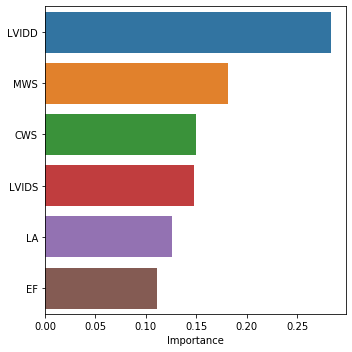

In [129]:
xgb_fscores=pd.DataFrame(xgb_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_imp.columns, xgb_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

xgb_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

plt.figure(figsize=(5, 5))
importances=xgb_importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y=importances.index, data=importances)
plt.tight_layout()

The rank of features here is not the same as that got from RandomForestClassifier. But, at least the top 1 and the bottom 1 are the same.

<a id='conclusion'></a>
## Conclusion

Based on the dataset and the very limited information, I have built two classifiers: RandomForest and XGBoost classifiers. According to the metrics -- AUC, I believe this two models are good enough to make accurate prediction on test data.

If I have more time, I'd like to do:
1. tune more hyperparameters for both models to get higher AUC.
2. explore features carefully, like outliers detection.
3. try some methods for feature selection, such as use importances to select features, chi-square test, and other more complex methods.
4. built more models, and ensemble them to get better prediction.

From my results, I think the six variables: LVIDD, LVIDS, MWS, CWS, LA and EF can adequately predict wheter the patient does or does not have left ventricular hypertrophy that should receive therapeutic attension. 

Since I used python for this challenge, honestly I don't know how to get the predictive interval for classification problem. If I have more time, I would like to do some research work to figure out this problem. I guess this question could be answered easily by using SAS. Unfortunately, I don't have access to SAS. 